## Stereo Disparity and Point cloud construction

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Kitti dataset

Using a stereo camera based platform to generate point clouds
Example left image

(KITTI odometry 21)

![KITTI Dataset example](../dataset/sequences/21/image_2/000000.png)


In [2]:
DATASET = 'dataset/sequences/00'

In [3]:
# Read the calibration information
calib = pd.read_csv(f'{DATASET}/calib.txt', delimiter=' ', header=None, index_col=0)
calib.head()

P0 = np.array(calib.loc["P0:"]).reshape((3, 4))
P1 = np.array(calib.loc["P1:"]).reshape((3, 4))
P2 = np.array(calib.loc["P2:"]).reshape((3, 4))
P3 = np.array(calib.loc["P3:"]).reshape((3, 4))
P2
P3

array([[ 7.188560e+02,  0.000000e+00,  6.071928e+02, -3.372877e+02],
       [ 0.000000e+00,  7.188560e+02,  1.852157e+02,  2.369057e+00],
       [ 0.000000e+00,  0.000000e+00,  1.000000e+00,  4.915215e-03]])

Extract the camera instrics in extrisics from the project matrix.
We only need P2 and P3 decomposed because these are the color camera pairs

In [4]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

k_left, r_left, t_left = decompose_projection_matrix(P2)
k_right, r_right, t_right = decompose_projection_matrix(P3)

print('Intrinsic Matrix:')
print(k_left)
print('Rotation Matrix:')
print(r_left)
print('Translation Vector:')
print(t_left.round(4))

Intrinsic Matrix:
[[718.856    0.     607.1928]
 [  0.     718.856  185.2157]
 [  0.       0.       1.    ]]
Rotation Matrix:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Translation Vector:
[[-0.0599]
 [ 0.0011]
 [-0.0038]]


In [5]:
def load_img(index: int, left=True, rgb=False, verbose=False):
    path = f'{DATASET}/image_{2 if left else 3}/{"%06d" % index}.png'
    img = cv2.imread(path)

    if verbose:
        print("Left: ", path)

    if rgb:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

### Disparity

Disparity will be done with OpenCV's SGBM (Semi-global block matching)

In [18]:
sad_window = 6
num_disparities = sad_window*16
matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                blockSize=11,
                                P1 = 8 * 3 * sad_window ** 2,
                                P2 = 32 * 3 * sad_window ** 2,
                                mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
#matcher = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=11)
def compute_disparity(img_left, img_right):
    return matcher.compute(img_left, img_right).astype(np.float32)/16

In [7]:
%matplotlib inline

Left:  dataset/sequences/00/image_2/000654.png


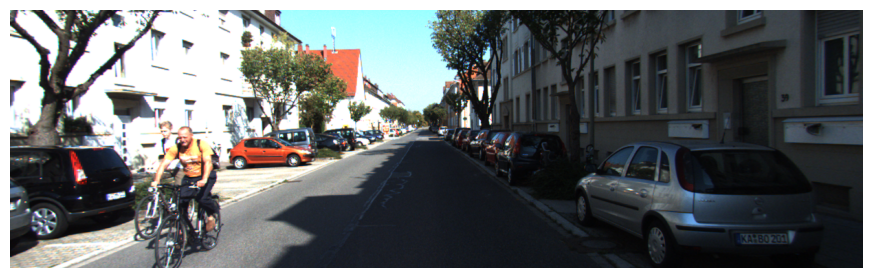

In [11]:
left_rgb, _ = load_img(654, rgb=True, verbose=True), load_img(654, left=False)
plt.figure(figsize=(11,7))
plt.axis('off')
plt.imshow(left_rgb)

Left:  dataset/sequences/00/image_2/000654.png


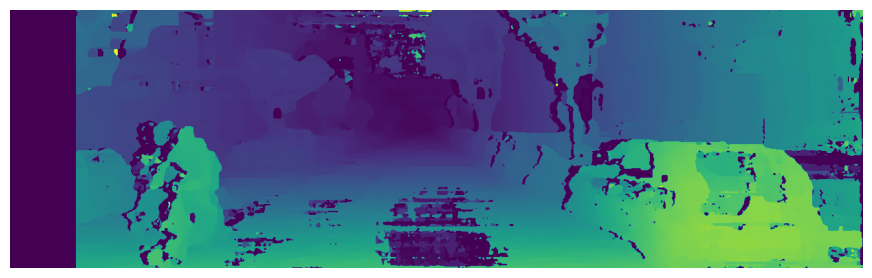

In [19]:
# Compute disparity using StereoBM
left_rgb, right = load_img(654, rgb=True, verbose=True), load_img(654, left=False)
left = cv2.cvtColor(left_rgb, cv2.COLOR_BGR2GRAY)
disp = compute_disparity(left, right)
plt.figure(figsize=(11,7))
plt.axis('off')
plt.imshow(disp)

In [ ]:
disp = compute_disparity(left, right)

In [82]:
def compute_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    # Get focal length of x axis for left camera
    f = k_left[0][0]
    
    # Calculate baseline of stereo pair
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    # Avoid instability and division by zero
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    # Make empty depth map then fill with depth
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

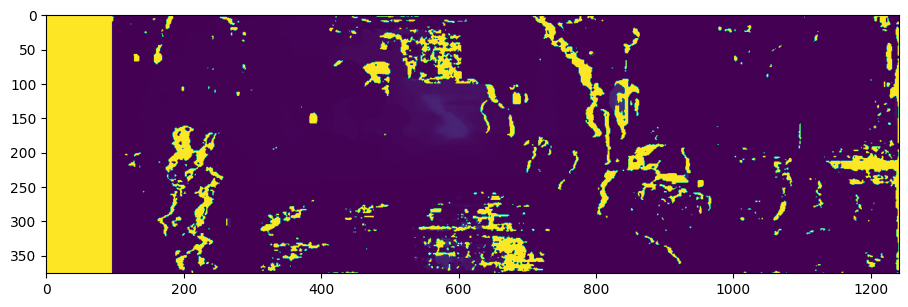

In [83]:
depth = compute_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.imshow(depth);

Mask out the left information caused by missing pixels from the right camera

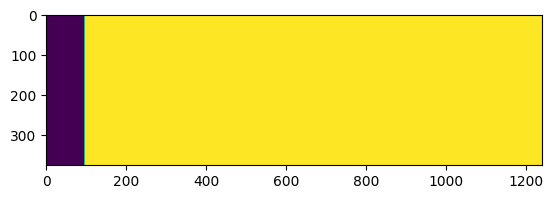

In [84]:
mask = np.zeros(left.shape[:2], dtype=np.uint8)
ymax = left.shape[0]
xmax = left.shape[1]
cv2.rectangle(mask, (96,0), (xmax,ymax), (255), thickness = -1)
plt.imshow(mask)

## Point cloud creation
Use Open3d to generate pointcloud from RGBD data

(376, 1241, 3)


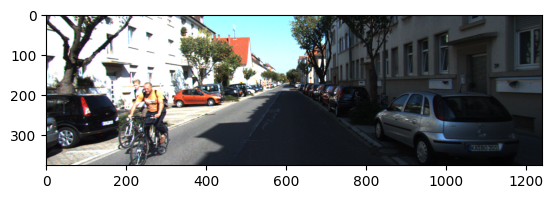

In [85]:
plt.imshow(left_rgb)
print(left_rgb.shape)

Create Open3D camera intrinsics.
Only the left instrinsic is required since the depth and color images are in the left camera frame

In [86]:
left_instrinsic = o3d.camera.PinholeCameraIntrinsic()
left_instrinsic.intrinsic_matrix = k_left
left_extrinsic = np.vstack((np.hstack((r_left, t_left[:])), [0, 0, 0 ,1]))

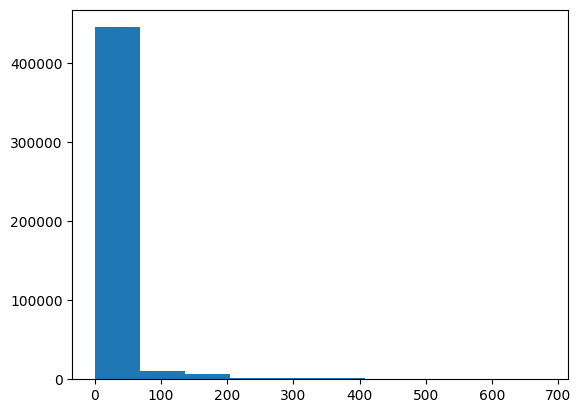

In [87]:
depth[depth > 2800] = 0
depth[depth < 10] = 0
plt.hist(depth.flatten());

In [88]:
camera_viz_settings = {
    "front": [0.014392043076128135, -0.10822775091813334, -0.99402194293048562],
    "lookat": [0.053646616053302051, 0.040506124347246257, 0.40058355541071416],
    "up": [0.058833764910271889, -0.99231085930482543, 0.10889328084047194],
    "zoom": 0.58000000000000018
}


def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      **camera_viz_settings)


In [89]:
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    o3d.geometry.Image(left_rgb.astype(np.uint8)),
    o3d.geometry.Image(depth.astype(np.float32)))

pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    left_instrinsic,
    left_extrinsic
)

Remove outlier points

In [90]:
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=10, std_ratio=1.4)
display_inlier_outlier(pcd, ind)

Showing outliers (red) and inliers (gray): 


Display the final point cloud

In [92]:
inlier_cloud = pcd.select_by_index(ind)

o3d.visualization.draw_geometries([inlier_cloud], **camera_viz_settings)